# Eval Diffusion Model
### Imports

In [35]:
try: 
    import librosa
except:
    !pip install librosa

#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))
# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader
import torch.optim as optim
# Utils
import numpy as np
from numpy import ndarray
import logging

# Base Scripts
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.Utils import *
from MainScripts.Conf import conf

### Conf

In [36]:
remote_kernel: bool = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name: str = "diffusion_v10_epoch_020"
training_data_name: str = "training_full_low_res"
model_path: str = path_to_remote_path("{}/{}".format(conf["paths"].model_path, model_name + ".pth"), remote_kernel)
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Functions

In [37]:
def bwd_pass(model: Diffusion, n_samples: int = 1, file_name: str = "test") -> None:
    x: ndarray = model.bwd_diffusion(n_samples=n_samples)
    print(x[0,0].shape)
    for i in range(x.shape[0]):
        logger.info(f"Sample {i}")
        visualize_spectogram(x[i, 0])
        audio = spectrogram_to_audio(unnormalize(x[i, 0]), conf["audio"].len_fft)
        save_audio_file(audio, path_to_remote_path("{}/{}".format(conf["paths"].result_path, f"{file_name}_{i:02d}_out.wav"), remote_kernel))
    logger.light_debug("Saved passed through samples to {}".format(conf["paths"].result_path))



def print_eval_metrics(data: ndarray) -> None:
    if data.ndim == 2:
        data = np.expand_dims(data, axis = 0)
    for i, sample in enumerate(data):
        sc_score = spectral_convergence(sample, len_fft=conf["audio"].len_fft, hop_length=conf["audio"].len_hop, sample_rate=conf["audio"].sample_rate)
        sdr_score = sdr(sample, sample_rate=conf["audio"].sample_rate, cutoff=4000)
        print(f"Sample {(i + 1):02d} Spectral Convergence: {sc_score:.4f} SDR score: {sdr_score:.2f} dB")


### Data Loading & Model Creation

In [38]:
file = load_training_data(path_to_remote_path("{}/{}".format(conf["paths"].data_path, training_data_name + ".npy"), remote_kernel))[:100,...]
logger.info(f"Data loaded with shape: {file.shape}")

u_net = Conv_U_NET(in_channels=1,
                    time_embed_dim=conf["model"].time_embed_dim, 
                    n_starting_filters=conf["model"].n_starting_filters, 
                    n_downsamples=conf["model"].n_downsamples, 
                    activation=nn.GELU(), 
                    device=device
                ).to(device)

if os.path.exists(model_path):
    u_net.load_state_dict(torch.load(model_path, map_location=device)["model"])
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: assert(f"No Model with {model_name} found!")

diffusion = Diffusion(model=u_net, 
                        noise_steps=conf["model"].diffusion_timesteps, 
                        noise_schedule="linear", 
                        input_dim=[conf["model"].batch_size, 1, file.shape[-2], file.shape[-1]],
                        device=device
                    )


2025-03-19 10:15:57,002 - INFO - Data loaded with shape: (100, 224, 416)


### Evaluate

In [39]:
#bwd_pass(diffusion, n_samples=8, file_name="test")
#x: ndarray = diffusion.bwd_diffusion_ddim(n_samples=8, sampling_timesteps=100, eta = 0)
x: ndarray = diffusion.bwd_diffusion_ddpm(n_samples=8)

2025-03-19 10:15:57,507 - INFO - Started sampling 8 samples
2025-03-19 10:19:38,490 - INFO - Created 8 samples


-875.4123 1106.3689


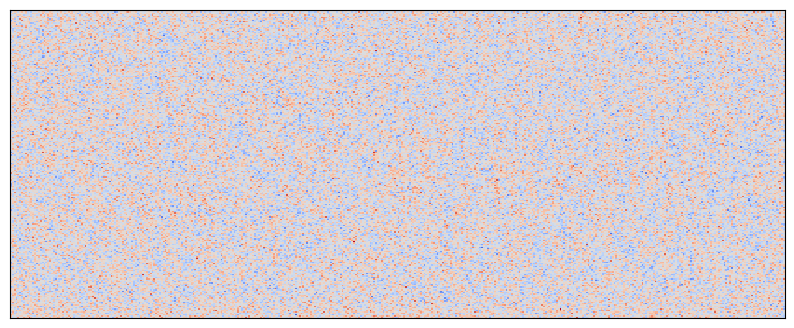

-876.25165 1051.0848


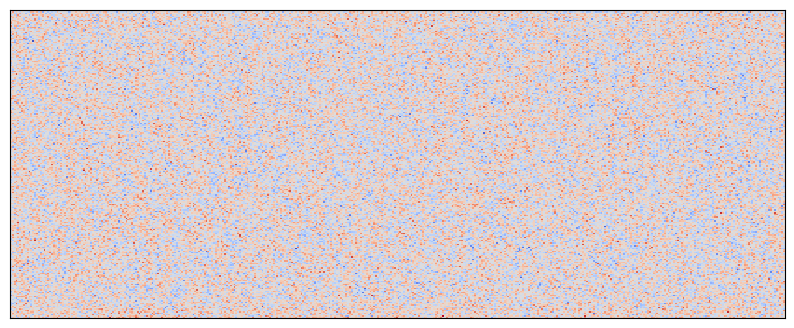

-817.1358 1089.2616


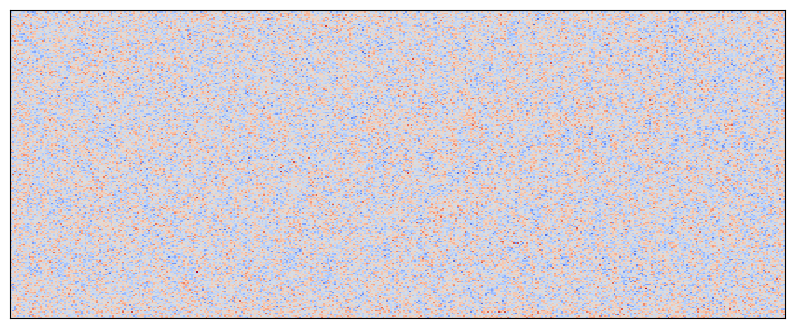

-874.36456 1138.0146


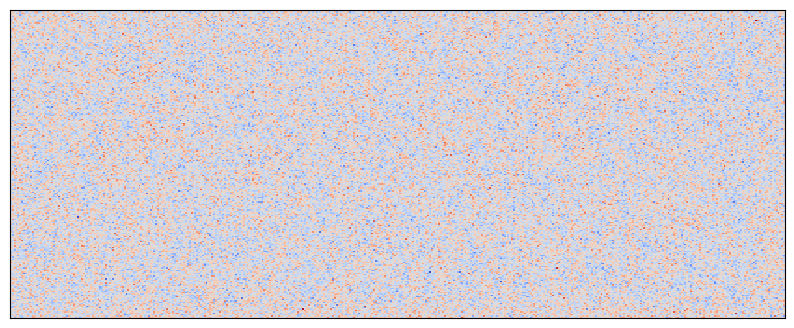

-907.6452 1007.5263


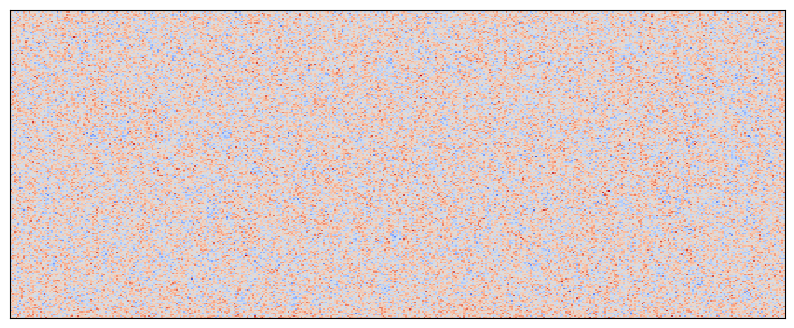

-919.9745 984.9734


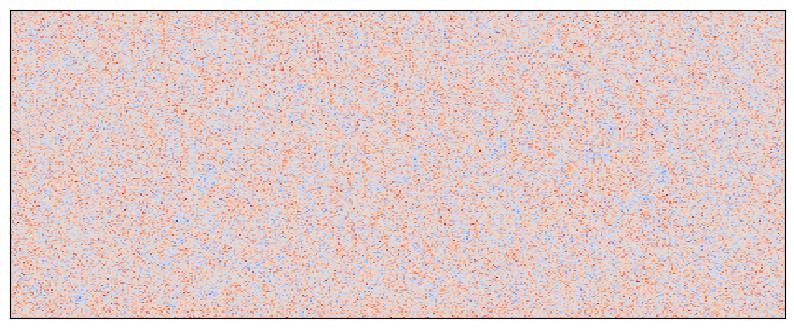

-836.32477 1053.072


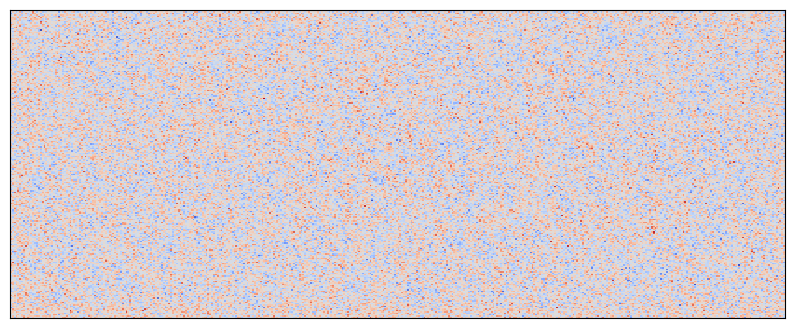

-926.10474 1073.3458


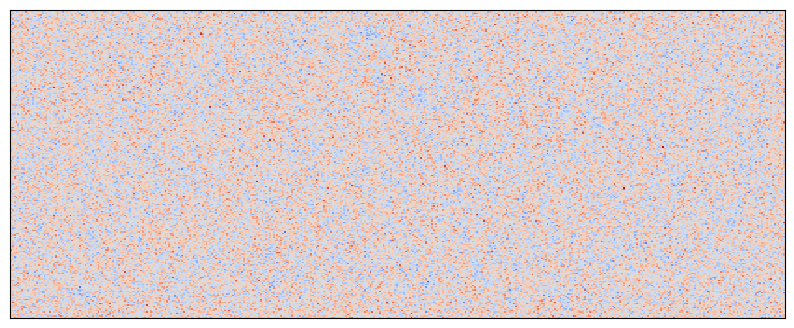

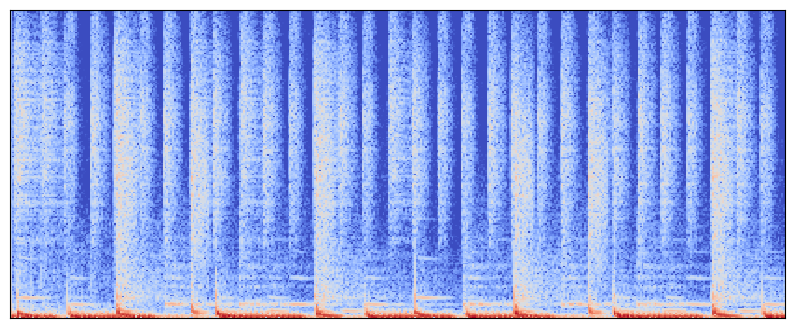

In [40]:
#print_eval_metrics(x)
for i in range(x.shape[0]):
    print(np.min(x[i,0]), np.max(x[i,0]))
    visualize_spectogram(x[i,0])
#save_audio_file(spectrogram_to_audio(unnormalize(x[0,0]), conf["audio"].len_fft, conf["audio"].len_hop), path_to_remote_path("{}/{}".format(conf["paths"].result_path, "test.wav"), remote_kernel), conf["audio"].sample_rate)
visualize_spectogram(file[8])


### Save Model Architecture

In [41]:
u_net.eval()
with torch.no_grad():
    u_net.eval()
with torch.no_grad():
    example_x = torch.randn(8, 1, file.shape[-2], file.shape[-1]).to(device)
    example_t = torch.randint(0, 500, (8,), dtype=torch.long).to(device)

    script_model = torch.jit.trace(u_net,(example_x, example_t), check_trace=False)
torch.jit.save(script_model, path_to_remote_path("{}/{}".format(conf["paths"].result_path, model_name + ".pt"), remote_kernel))
#torchviz.make_dot(model(torch.randn(BATCH_SIZE, 1, file.shape[-2], file.shape[-1])), params=dict(model.named_parameters())).render(f"{RESULT_PATH}/{model_name}", format="png") #Not working
#logger.info(f"Saved model {path_to_remote_path(f"{RESULT_PATH}/{model_name}.pt", remote_kernel)}")